# Librairies

In [2]:
import glob
from pathlib import Path
import os
import sys
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import geopandas as gpd

from PIL import Image, ImageMath

import math

import warnings
import logging

from keras.layers import Input, Dense, Conv1D, Conv2D, concatenate, Flatten, MaxPooling2D, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam, RMSprop, SGD
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.regularizers import l1 
    
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MinMaxScaler

from pytictoc import TicToc

from numpy.random import seed
seed(1)



/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
rootDir = '/home/charles/Projects/NeuralNetPopulation'
provider = 'Mapbox'
gridSize = 100
resp="v_CA16_406"
finalNonLin = 'linear'
optimizerClass = Adam
lrInit=10**-2

In [4]:
sys.path.append("/home/charles/Projects/NeuralNetPopulation/Python") #watch out, PosixPath do not work

from dataGeneration.dataGeneratorFactory import DataGeneratorFactory
from dataGeneration.rawDataInput import RawDataInput

from models.convNetParams import ConvNetParams
from models.mdlFit import MdlFit
from utils.pathBuilder import PathBuilder

In [6]:
checkpointPath = Path("/home/charles/Projects/NeuralNetPopulation/Data/Models/Checkpoint/Mapbox/100")

# Load the model, and dataloader objects

In [24]:
myPathBuilder = PathBuilder(rootDir,
                                provider,
                                gridSize)

myRawDataInput = RawDataInput(myPathBuilder,
                                  idGrid='gridId',
                                  provider=provider,
                                  gridSize=gridSize,
                                  resp=resp,
                                  ubNumTotal=np.inf)  # consider all the data

myConvNetParams = ConvNetParams(provider=provider,
                                    gridSize=gridSize,
                                    resp=myRawDataInput.resp,
                                    dim=myRawDataInput.dim,
                                    numImgs=myRawDataInput.numImgs,
                                    finalNonLin=finalNonLin,
                                    lr=lrInit,
                                    numEpochs=20,
                                    batchSize=2 ** 5,
                                    l1Coeff=0,
                                    dropoutRate=0.1,
                                    convNetClass=VGG19,
                                    scalerClass=MinMaxScaler,
                                    shuffle=False,
                                    verbose=True)

myDatageneratorFactory = DataGeneratorFactory(myRawDataInput,
                                                  myConvNetParams,
                                                  myPathBuilder)

dictTrainTestValid=myDatageneratorFactory.getTrainTestValidDataGenerators()

mdl = load_model(checkpointPath /"Mapbox_v_CA16_406_VGG19_gridSize_100_lr_0.005_batchSize_32_numEpochs_30_l1Coeff_0_dropoutRate_0_numImgs_4104_scalerMinMaxScaler_optimizerName_SGDfinalNonLinearity_linear_penultimateNonLin_elu_checkpoint_loss.h5")

Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/PredictionError/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/Partition/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Figures/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/FinalModel/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/ModelHistory/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Log/mdlFittingLogs/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/Checkpoint/Mapbox/100 already exists
Directory /home/charles/Projects/NeuralNetPopulation/Data/Models/FeatureMaps/Mapbox/100 already exists
All train, test, valid indices already exist for Mapbox_v_CA16_406_VGG19_gridSize_100_lr_0.01_batchSize_32_numEpochs_20_l1Coeff_0_dropoutRate_0.1_numImgs_4104_scalerMinMaxScaler_optimizerName_SGDf

In [8]:
numImgBatches=1 #batches of 32
maxNumImgs=2

if numImgBatches > 5 or maxNumImgs > 10**3:
    raise Exception("You will run out of RAM! Use generators, don't try to load the entire set of images into memory at once")

# Evaluate predictions and errors

## Get the train and test sets

In [9]:
trainGenerator = dictTrainTestValid['train']
testGenerator = dictTrainTestValid['test']

In [10]:
listTupleXyTrain = [ (X,y) for k,(X,y) in enumerate(trainGenerator) if k <= numImgBatches ]
listTupleXyTest = [ (X,y) for k,(X,y) in enumerate(testGenerator) if k <= numImgBatches ]

In [11]:
X,y=trainGenerator[0]
X.shape, y.shape, listTupleXyTrain[0][0].shape, listTupleXyTrain[0][1].shape

((32, 480, 480, 3), (32, 1), (32, 480, 480, 3), (32, 1))

In [12]:
yTrain = np.concatenate( [tup[1] for tup in listTupleXyTrain ])
yTest = np.concatenate(  [tup[1] for tup  in listTupleXyTest ])

numImgsTrain=min(maxNumImgs, yTrain.shape[0])
numImgsTest=min(maxNumImgs, yTest.shape[0])

yTrain=yTrain[:numImgsTrain]
yTest= yTest[:numImgsTest]

XTrain = np.concatenate( [tup[0]  for tup in listTupleXyTrain ] )
XTest = np.concatenate([tup[0]  for tup in listTupleXyTest] )

XTrain =XTrain [:numImgsTrain,:,:,:]
XTest =XTest [:numImgsTest,:,:,:]

yTrain.shape, yTest.shape, XTrain.shape, XTest.shape

((2, 1), (2, 1), (2, 480, 480, 3), (2, 480, 480, 3))

In [19]:
def evalMdlRawData(mdlFit, X, y):
    t=TicToc()
    t.tic()
    mse= mdl.evaluate( X, y)
    pred = mdl.predict( X)
    t.toc()
    
    return mse, pred

In [20]:
def checkDim(arr):
    
    if len(arr.shape) == 1:
        return T
    elif len(arr.shape) == 2 and arr.shape[1] ==1:
        return T
    else :
        raise Exception("The array should be a row or column vector")

In [25]:
def createDfPred(pred,obs):
    
    #Quick check
    map(checkDim, [pred,obs])
    
    #Create the dataframe
    df = pd.DataFrame.from_dict( {'pred' : pred.ravel(), 'obs': obs.ravel()},
                                  orient='columns') 
    df['error'] = df['obs'] - df['pred']
    return df



In [46]:
mseTrain, predTrain = evalMdlRawData (mdl, XTrain, yTrain  ) 
dfTrain = createDfPred(predTrain, yTrain)
dfTrain['id'] = 'train'
dfTrain['index'] = trainGenerator.indices[:dfTrain.shape[0]]
dfGrid = testGenerator.dfGrid.reset_index()
dfTrain= pd.merge(dfTrain, dfGrid, on='index')
mseTrainValidation= np.sum( dfTrain['error']**2)**0.5

1/1 [==============================] - 0s 2ms/step - loss: 0.0075
Elapsed time is 6.114651 seconds.


In [47]:
dfTrain.head()

pred       obs     error     id  index  Group.1   v_CA16_2213  \
0  0.195751  0.109304 -0.086447  train   3001       59  29185.641998   
1  0.195751  0.283061  0.087310  train   2009      108  23132.047893   

   v_CA16_2540    v_CA16_406                  gridId    GeoUID  \
0    18.734508   4204.202784          59saint-michel  24661669   
1    27.073525  10887.486851  108pointe_aux_trembles  24663276   

               Q_socio          neighTouching  numberNeigh  numberDA  \
0             Rosemont  Rosemont,Saint-Michel          2.0       2.0   
1  Pointe-aux-Trembles    Pointe-aux-Trembles          1.0       3.0   

                rastID                                            pathImg  
0         saint-michel  /home/charles/Projects/NeuralNetPopulation/Out...  
1  pointe_aux_trembles  /home/charles/Projects/NeuralNetPopulation/Out...

In [33]:
mseTest, predTest = evalMdlRawData (mdl, XTest, yTest ) 
dfTest = createDfPred(predTest, yTest)
dfTest ['id'] = 'test'
dfTest['index'] = testGenerator.indices[:dfTrain.shape[0]]
dfGrid = testGenerator.dfGrid.reset_index()
dfTest= pd.merge(dfTest, dfGrid, on='index')

mseTestValidation= np.sum( dfTest['error']**2)**0.5

1/1 [==============================] - 0s 2ms/step - loss: 0.0070
Elapsed time is 6.549698 seconds.


In [34]:
dfTest.head()

pred       obs     error    id  index  Group.1   v_CA16_2213  \
0  0.195751  0.085328 -0.110423  test    988       88  23104.000000   
1  0.195751  0.237617  0.041866  test     13       76  23916.036869   

   v_CA16_2540   v_CA16_406      gridId    GeoUID   Q_socio neighTouching  \
0    26.200000  3282.000000   88lasalle  24662176   LaSalle       LaSalle   
1    31.468213  9139.577272  76ahuntsic  24660512  Ahuntsic      Ahuntsic   

   numberNeigh  numberDA    rastID  \
0          1.0       1.0   lasalle   
1          1.0       4.0  ahuntsic   

                                             pathImg  
0  /home/charles/Projects/NeuralNetPopulation/Out...  
1  /home/charles/Projects/NeuralNetPopulation/Out...

## Plot the error distribution

In [48]:
dfTrainSubset= dfTrain.loc[:, ['pred','obs','Q_socio','id']]
dfTestSubset = dfTest.loc[:,['pred','obs','Q_socio','id']]
dfMelted = pd.melt( pd.concat([dfTrainSubset,dfTestSubset] ), id_vars= ['Q_socio','id'])
dfMelted

Q_socio     id variable     value
0             Rosemont  train     pred  0.195751
1  Pointe-aux-Trembles  train     pred  0.195751
2              LaSalle   test     pred  0.195751
3             Ahuntsic   test     pred  0.195751
4             Rosemont  train      obs  0.109304
5  Pointe-aux-Trembles  train      obs  0.283061
6              LaSalle   test      obs  0.085328
7             Ahuntsic   test      obs  0.237617

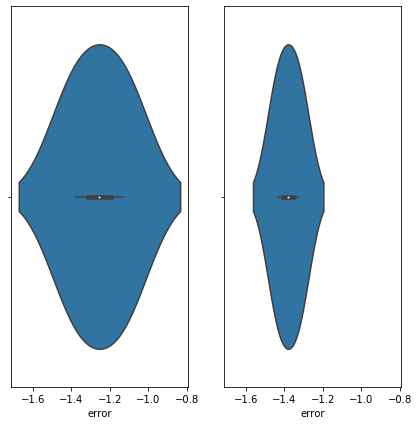

In [17]:
f, axes = plt.subplots(1, 2, figsize=(7, 7), sharex=True)

sns.violinplot(x='error',hue="id", data= dfTrain, ax=axes[0])
sns.violinplot(x='error',hue="id", data=dfTest, ax=axes[1])

In [54]:
g = sns.FacetGrid(dfMelted, col="id", row='variable' , hue="id")
g.map( sns.distplot, 'value' )  

/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


# By neighbourhood

In [55]:
g = sns.FacetGrid(dfMelted, col="id", row='variable' , hue="id")
g.map( sns.violinplot, 'value', 'Q_socio' )  